In [1]:
from networkx.classes import edges
from temporal_walk import TemporalWalk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random

def generate_temporal_edges(num_edges=50000, num_nodes=1000, time_start=1_400_000_000, time_end=1_500_000_000):
    """
    Generate a list of temporal edges for testing graph sampling algorithms.

    Args:
        num_edges (int): Total number of edges to generate.
        num_nodes (int): Number of unique nodes in the graph.
        time_start (int): Starting timestamp for edges.
        time_end (int): Ending timestamp for edges.

    Returns:
        list: A list of tuples (src_node, dest_node, timestamp).
    """
    edges = []

    for _ in range(num_edges):
        src_node = random.randint(0, num_nodes - 1)
        dest_node = random.randint(0, num_nodes - 1)

        # Ensure no self-loops
        while dest_node == src_node:
            dest_node = random.randint(0, num_nodes - 1)

        # Randomly generate a timestamp in the specified range
        timestamp = random.randint(time_start, time_end)

        # Append the edge as a tuple
        edges.append((src_node, dest_node, timestamp))

    return edges

In [3]:
edges = generate_temporal_edges()

In [4]:
NUM_WALKS = 100000
LEN_WALK = 50

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from scipy.stats import skew

def evaluate_picker_properties_with_time_boundaries(edges):
    picker_types = ["Uniform", "Linear", "Exponential"]
    MIN_TIMESTAMP = -9223372036854775808
    MAX_TIMESTAMP = 9223372036854775807
    
    results = {}
    time_results = {}
    node_visit_stats = {}
    timestamp_stats = {}
    
    for picker in picker_types:
        temporal_walk = TemporalWalk(NUM_WALKS, LEN_WALK, picker, None)
        temporal_walk.add_multiple_edges(edges)
        random_walks_with_times = temporal_walk.get_random_walks_with_times("End")
        
        node_visits = defaultdict(int)
        timestamp_frequencies = defaultdict(int)

        for walk in random_walks_with_times:
            for node, time in walk:
                node_visits[node] += 1
                if MIN_TIMESTAMP < time < MAX_TIMESTAMP:
                    # Bin timestamps into intervals for better visualization
                    time_bin = (time // 1_000_000) * 1_000_000
                    timestamp_frequencies[time_bin] += 1
        
        # Store node and timestamp data
        results[picker] = node_visits
        time_results[picker] = timestamp_frequencies
        
        # Compute statistics for nodes and timestamps
        node_visit_stats[picker] = {
            "mean": np.mean(list(node_visits.values())),
            "median": np.median(list(node_visits.values())),
            "std_dev": np.std(list(node_visits.values())),
            "skewness": skew(list(node_visits.values()))
        }
        
        timestamp_stats[picker] = {
            "mean": np.mean(list(timestamp_frequencies.values())),
            "std_dev": np.std(list(timestamp_frequencies.values())),
            "skewness": skew(list(timestamp_frequencies.values()))
        }

    # Create the plot with additional statistical context
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Plot node visit frequencies with histograms
    for i, picker in enumerate(picker_types):
        nodes = list(results[picker].keys())
        visits = list(results[picker].values())
        
        # Log scale for exponential distribution
        if picker == "Exponential":
            axes[0, i].hist(nodes, bins=100, weights=visits, color='red', alpha=0.6, log=True)
        else:
            axes[0, i].hist(nodes, bins=100, weights=visits, color='red', alpha=0.6)
        
        axes[0, i].set_title(f"Node Visit Frequencies ({picker} Picker)")
        axes[0, i].set_xlabel("Node ID")
        axes[0, i].set_ylabel("Visit Count")
        axes[0, i].text(0.05, 0.95, f"Mean: {node_visit_stats[picker]['mean']:.2f}\nSkewness: {node_visit_stats[picker]['skewness']:.2f}",
                        transform=axes[0, i].transAxes, fontsize=12, verticalalignment='top')

    # Plot timestamp distributions with binned data
    for i, picker in enumerate(picker_types):
        times = list(time_results[picker].keys())
        counts = list(time_results[picker].values())
        
        axes[1, i].bar(times, counts, width=np.mean(np.diff(sorted(times))), color='blue', alpha=0.6)
        
        axes[1, i].set_title(f"Timestamp Frequencies ({picker} Picker)")
        axes[1, i].set_xlabel("Timestamp (binned)")
        axes[1, i].set_ylabel("Frequency")
        
        # Format x-axis to show billions
        axes[1, i].xaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, p: f'{x/1e9:.2f}B'))
        axes[1, i].text(0.05, 0.95, f"Mean: {timestamp_stats[picker]['mean']:.2f}\nSkewness: {timestamp_stats[picker]['skewness']:.2f}",
                        transform=axes[1, i].transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    return fig

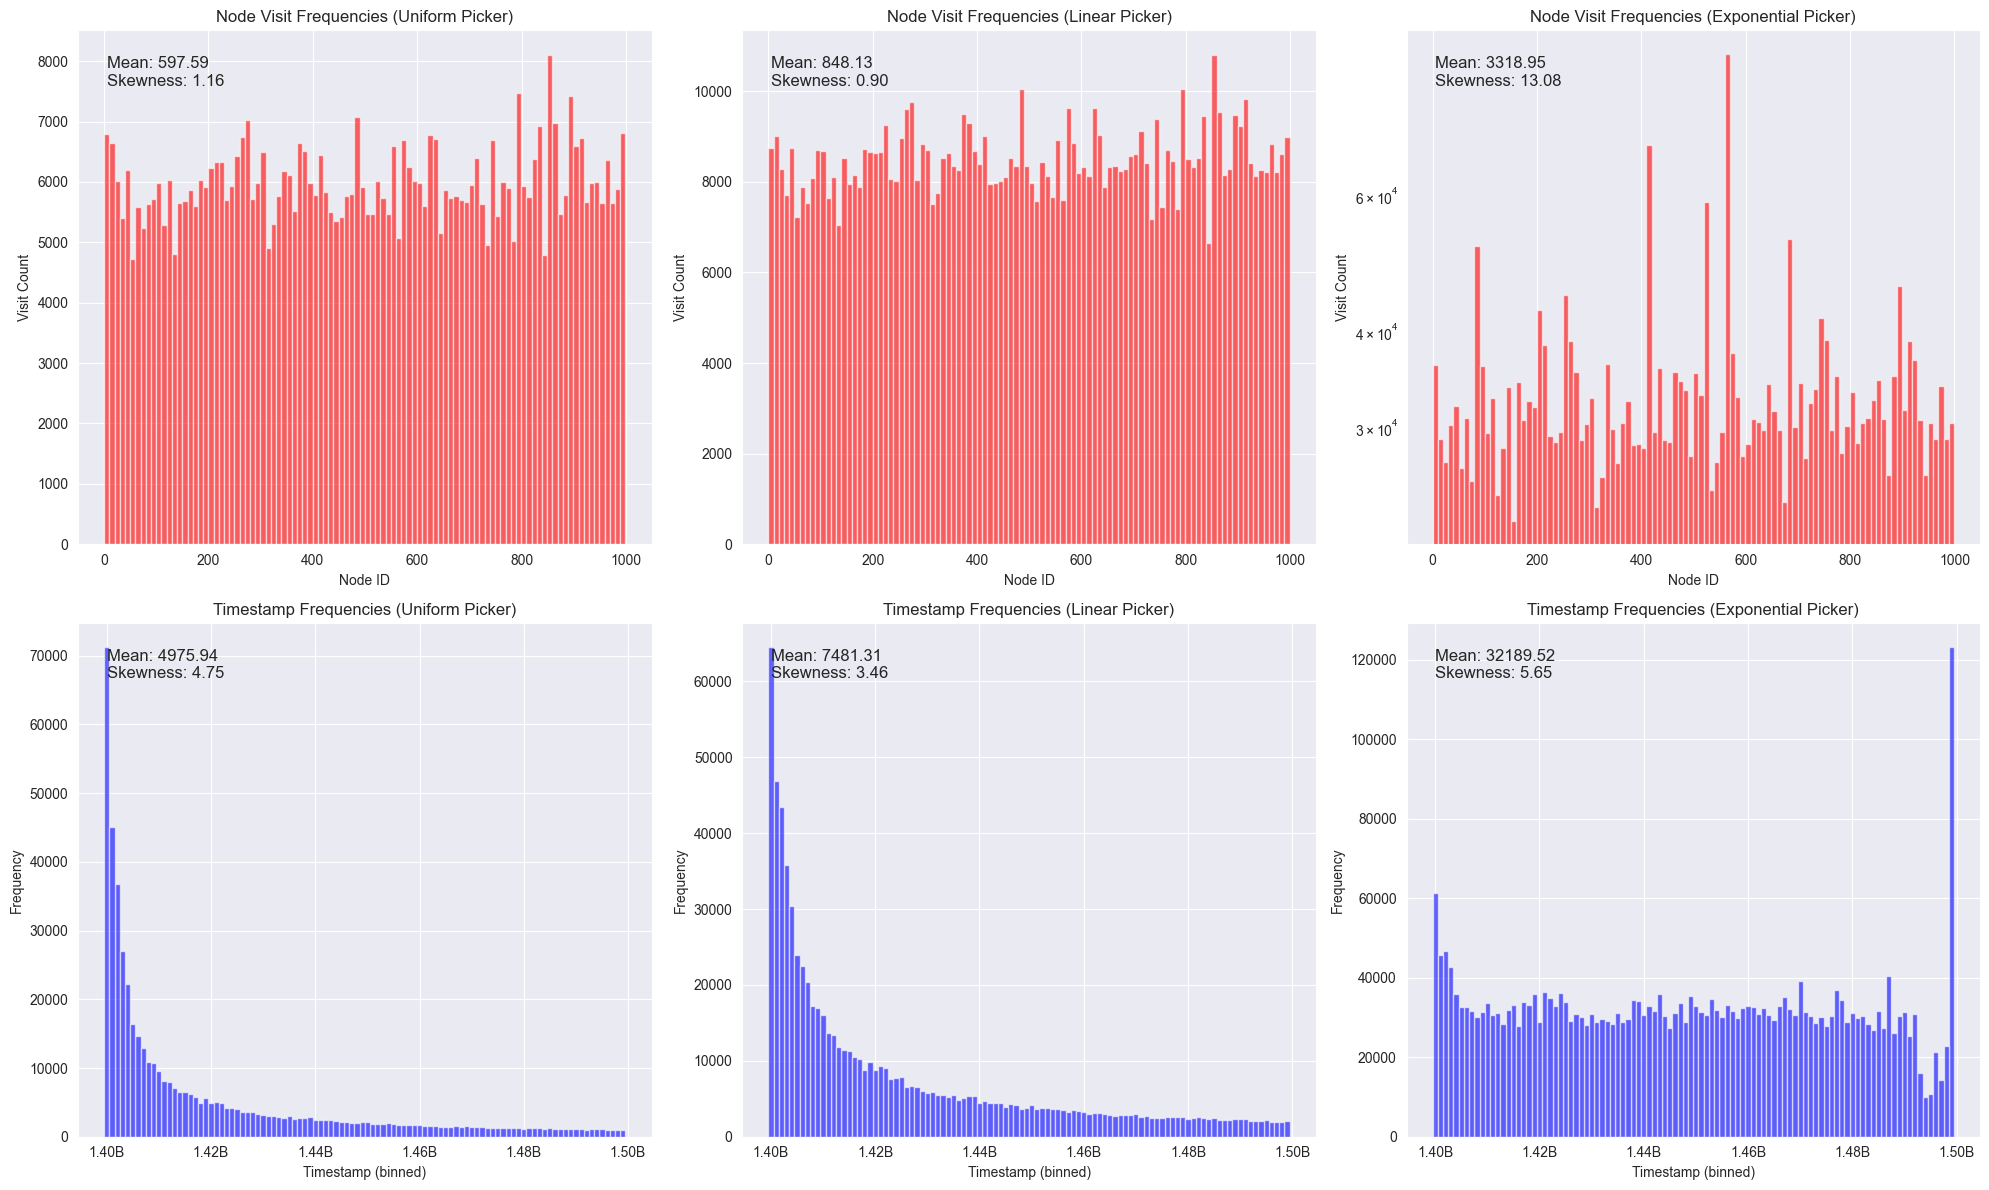

In [6]:
evaluate_picker_properties_with_time_boundaries(edges)
plt.savefig('plots/picker_comparison_new.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
tw = TemporalWalk(
    num_walks=500_000,
    len_walk=200,
    picker_type="Exponential",
    max_time_capacity=None
)

In [8]:
tw.add_multiple_edges(edges)

In [9]:
walks = tw.get_random_walks_with_times("End")

In [10]:
walks[:100]

[[(380, 1400460858),
  (867, 1400526390),
  (255, 1400854358),
  (388, 1401471161),
  (768, 1401493269),
  (99, 1403300274),
  (522, 1406896885),
  (728, 1409029191),
  (144, 1411192518),
  (333, 1412294161),
  (391, 1413139106),
  (394, 1417644577),
  (114, 1419488005),
  (491, 1424474747),
  (911, 1424764045),
  (921, 1431711158),
  (837, 1435435391),
  (981, 1438854312),
  (479, 1442480561),
  (153, 1454177220),
  (635, 1455163835),
  (780, 1457321981),
  (22, 1464186828),
  (242, 1470479826),
  (399, 1475323660),
  (240, 1476798336),
  (574, 1480187536),
  (899, 1490135745),
  (567, 9223372036854775807)],
 [(600, 1401172293),
  (464, 1404507294),
  (306, 1412441761),
  (476, 1412826522),
  (237, 1412984430),
  (85, 1415376854),
  (773, 1419282883),
  (59, 1425030483),
  (96, 1433013655),
  (572, 1434737737),
  (374, 1438794658),
  (901, 1443118571),
  (335, 1447329128),
  (728, 1447598764),
  (537, 1450054506),
  (886, 1453455439),
  (953, 1456720843),
  (991, 1457603538),
  (539, 

In [11]:
walks = tw.get_random_walks_with_times("Begin")

In [12]:
walks[:100]

[[(598, -9223372036854775808),
  (9, 1400001979),
  (450, 1400191648),
  (972, 1400193575),
  (886, 1407874866),
  (385, 1412309457),
  (394, 1423798126),
  (481, 1424847610),
  (860, 1435856509),
  (813, 1437691665),
  (348, 1438704259),
  (929, 1445225517),
  (325, 1447045982),
  (44, 1447283908),
  (612, 1451737174),
  (17, 1453592094),
  (433, 1459427635),
  (158, 1459900463),
  (742, 1463528002),
  (3, 1466190294),
  (723, 1466722641),
  (91, 1470195917),
  (678, 1481919299),
  (206, 1482973349),
  (410, 1488057118),
  (12, 1488959000)],
 [(598, -9223372036854775808),
  (9, 1400001979),
  (549, 1400468896),
  (546, 1405205860),
  (175, 1405306128),
  (548, 1409611340),
  (515, 1414666431),
  (914, 1415746449),
  (930, 1418117161),
  (897, 1421226326),
  (447, 1423303604),
  (405, 1425091179),
  (840, 1431882936),
  (802, 1440672485),
  (222, 1444675681),
  (909, 1444899085),
  (736, 1445488494),
  (345, 1449582510),
  (282, 1451472981),
  (339, 1457759251),
  (785, 1457798858),
  